In [3]:
import os
import torch
import sklearn
from torch import nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd

In [4]:
def load_imdb_data(data_file, column):
    # Read the dataframe
    df = pd.read_csv(data_file)

    # Fill NaN values with 0 and replace -1 with 2
    df.fillna(0, inplace=True)
    df.replace(-1, 2, inplace=True)

    # Filter rows with labels 1 and 2
    df_filtered = df[df[column].isin([1, 2])]

    # Change labels for rows with label 2 to 0
    df_filtered.loc[df_filtered[column] == 2, column] = 0

    # Extract text and labels
    texts = df_filtered['reviewText'].tolist()
    labels = df_filtered[column].tolist()
    labels = [int(element) for element in labels]

    return texts, labels


In [5]:
data_file = "D:\ISE540\Team project\Amazonfoodnew - Amazonfoodnew.csv"
texts, labels = load_imdb_data(data_file,'packing/outter appearance/shipping')

C:\Users\12483\AppData\Roaming\Python\Python38\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


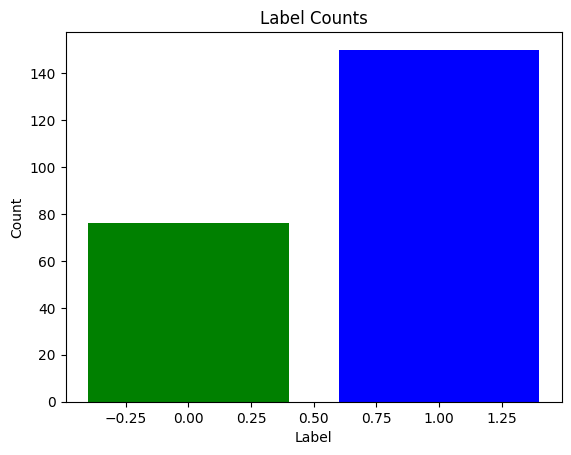

In [6]:
import matplotlib.pyplot as plt
# Count occurrences of each label
label_counts = {0: labels.count(0), 1: labels.count(1)}

# Plotting the bar chart
plt.bar(label_counts.keys(), label_counts.values(), color=['green', 'blue'])
plt.title('Label Counts')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [56]:
def get_wordnet_pos (tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [57]:
def lemmatize (word_list):
    wl = WordNetLemmatizer()
    word_pos_tags = pos_tag(word_list)
    lemmatized_list = []
    for tag in word_pos_tags:
        lemmatize_word = wl.lemmatize(tag[0],get_wordnet_pos(tag[1]))
        lemmatized_list.append(lemmatize_word)
    return " ".join(lemmatized_list)

In [58]:
def clean_text (text):
    # Remove Pre and Post Spaces
    text = str(text).strip()
    
    # Lower case the entire text
    text = str(text).lower()

    # Substitute New Line Characters with spaces 
    text = re.sub(r"\n", r" ", text)
        
    # Tokenize the sentence
    word_tokens = word_tokenize(text)
    
    # Remove the punctuation and  special characters from each individual word
    cleaned_text = []
    for word in word_tokens:
        cleaned_text.append("".join([char for char in word if char.isalnum()]))
    
    # Specify the stop words list
    stop_words = stopwords.words('english')
    important_words = list(tokenizer.word_index.keys())[:200]
    
    # Remove the stopwords and words containing less then 2 characters  ++and (word in important_words) 
    text_tokens = [word for word in cleaned_text if (len(word) > 2) and (word in important_words) and (word not in stop_words)]
    #text_tokens = [word for word in cleaned_text if (len(word) > 2) and (word not in stop_words)]
    
    #Lemmatize each word in the word list
    text = lemmatize (text_tokens)
    
    return text

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Assuming you have already loaded your data using the load_imdb_data function


# Split the data into training and testing sets
texts_train, texts_test, labels_train, labels_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Tokenize the text using CountVectorizer
vectorizer = CountVectorizer(max_features=5000)  # You can adjust max_features as needed
X_train = vectorizer.fit_transform(texts_train).toarray()
X_test = vectorizer.transform(texts_test).toarray()

# Convert the data to PyTorch tensors
# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.long)  # Change dtype to long
y_train_tensor = torch.tensor(labels_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.long)  # Change dtype to long
y_test_tensor = torch.tensor(labels_test, dtype=torch.float32)


# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Define the textCNN model
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embed_size, num_classes):
        super(TextCNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.conv1 = nn.Conv1d(embed_size, 128, kernel_size=3)
        self.conv2 = nn.Conv1d(128, 64, kernel_size=3)
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(0, 2, 1)  # Change the shape for Conv1d
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.max_pool1d(x, x.size(2)).squeeze(2)
        x = self.fc(x)
        return x

# Instantiate the model
vocab_size = X_train.shape[1]
embed_size = 50  # You can adjust embed_size as needed
num_classes = 1  # Binary classification
model = TextCNN(vocab_size, embed_size, num_classes)

# Loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 16
for epoch in range(num_epochs):
    model.train()
    for batch_X, batch_y in train_dataloader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y.view(-1, 1))
        loss.backward()
        optimizer.step()

# Evaluate the model
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    predictions = (torch.sigmoid(test_outputs) > 0.6).int().numpy()

# Calculate accuracy or other metrics based on your requirements
# accuracy = (predictions == y_test_tensor.numpy().reshape(-1, 1)).mean()
conf_matrix = confusion_matrix(labels_test, predictions)
precision = precision_score(labels_test, predictions)
recall = recall_score(labels_test, predictions)
f1 = f1_score(labels_test, predictions)

# Print or use precision, recall, and F1-score as needed
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
# print(f"Confusion Matrix:\n{conf_matrix}")
# print(f"Test Accuracy: {accuracy}")


Precision: 0.7619
Recall: 0.8889
F1-Score: 0.8205


In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer

# Tokenize the text using TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=5000)  # You can adjust max_features as needed
X_train_tfidf = vectorizer.fit_transform(texts_train).toarray()
X_test_tfidf = vectorizer.transform(texts_test).toarray()

# Assuming you have already loaded your data using the load_imdb_data function


# Split the data into training and testing sets
texts_train, texts_test, labels_train, labels_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Tokenize the text using CountVectorizer
vectorizer = TfidfVectorizer(max_features=5000)  # You can adjust max_features as needed
X_train_tfidf = vectorizer.fit_transform(texts_train).toarray()
X_test_tfidf = vectorizer.transform(texts_test).toarray()

# Convert the data to PyTorch tensors
# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.long)  # Change dtype to long
y_train_tensor = torch.tensor(labels_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.long)  # Change dtype to long
y_test_tensor = torch.tensor(labels_test, dtype=torch.float32)


# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Define the textCNN model
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embed_size, num_classes):
        super(TextCNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.conv1 = nn.Conv1d(embed_size, 128, kernel_size=3)
        self.conv2 = nn.Conv1d(128, 64, kernel_size=3)
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(0, 2, 1)  # Change the shape for Conv1d
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.max_pool1d(x, x.size(2)).squeeze(2)
        x = self.fc(x)
        return x

# Instantiate the model
vocab_size = X_train.shape[1]
embed_size = 50  # You can adjust embed_size as needed
num_classes = 1  # Binary classification
model = TextCNN(vocab_size, embed_size, num_classes)

# Loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 16
for epoch in range(num_epochs):
    model.train()
    for batch_X, batch_y in train_dataloader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y.view(-1, 1))
        loss.backward()
        optimizer.step()

# Evaluate the model
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    predictions = (torch.sigmoid(test_outputs) > 0.65).int().numpy()

# Calculate accuracy or other metrics based on your requirements
# accuracy = (predictions == y_test_tensor.numpy().reshape(-1, 1)).mean()
conf_matrix = confusion_matrix(labels_test, predictions)
precision = precision_score(labels_test, predictions)
recall = recall_score(labels_test, predictions)
f1 = f1_score(labels_test, predictions)

# Print or use precision, recall, and F1-score as needed
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
# print(f"Confusion Matrix:\n{conf_matrix}")
# print(f"Test Accuracy: {accuracy}")

Precision: 0.8571
Recall: 0.3333
F1-Score: 0.4800
